<h1> Random Forest Model </h1>

In [18]:
# RF imports

import numpy as np
import pandas as pd
from numpy import array
import time
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

%matplotlib inline
set_matplotlib_formats('svg')
sns.set_style("darkgrid")

In [19]:
# read the data
data = pd.read_csv('FINAL_DATASET.csv')
data.head()

Unnamed: 0 ISO_Code  DAY        Date  TOTAL_CO2_MED  PWR_CO2_MED  \
0           0      AUT    1  2020-01-01            0.0          0.0   
1           1      AUT    2  2020-01-02            0.0          0.0   
2           2      AUT    3  2020-01-03            0.0          0.0   
3           3      AUT    4  2020-01-04            0.0          0.0   
4           4      AUT    5  2020-01-05            0.0          0.0   

   IND_CO2_MED  TRS_CO2_MED  PUB_CO2_MED  RES_CO2_MED  ...  H2_Testing policy  \
0          0.0          0.0          0.0          0.0  ...                0.0   
1          0.0          0.0          0.0          0.0  ...                0.0   
2          0.0          0.0          0.0          0.0  ...                0.0   
3          0.0          0.0          0.0          0.0  ...                0.0   
4          0.0          0.0          0.0          0.0  ...                0.0   

   H3_Contact tracing  H4_Emergency investment in healthcare  \
0                 0.0                                    0.0   
1                 0.0                                    0.0   
2                 0.0                                    0.0   
3                 0.0                                    0.0   
4                 0.0                                    0.0   

   H5_Investment in vaccines  StringencyIndex  GovernmentResponseIndex  \
0                        0.0              0.0                      0.0   
1                        0.0              0.0                      0.0   
2                        0.0              0.0                      0.0   
3                        0.0              0.0                      0.0   
4                        0.0              0.0                      0.0   

   ContainmentHealthIndex  EconomicSupportIndex  IndustrialProduction  \
0                     0.0                   0.0                117.27   
1                     0.0                   0.0                117.27   
2                     0.0                   0.0                117.27   
3                     0.0                   0.0                117.27   
4                     0.0                   0.0                117.27   

   unemployment_rate  
0           6.004297  
1           6.004297  
2           6.004297  
3           6.004297  
4           6.004297  

[5 rows x 100 columns]

In [20]:
# drop columns containing NaN, possibility to normalize, currently deactivated

for col in list(data):
    length = len(data)
    
    if not (col == 'TOTAL_CO2_MED' or col == 'new_cases_per_million' or col == 'DAY'):

        if type(data[col][140]) is not type(''):
            #print('do nothin')
            #print(type(data[col][140]))
            data[col]=data[col]*1#(data[col]-data[col].min())/(data[col].max()-data[col].min())
            #print('Nomalized')
        
        if int((data[col].isnull().sum()/length)*100) > 0:
            data =data.drop(col,axis=1)
            print('dropped: ', col)

In [21]:
#for col in list(data):
#    length = len(data)
#    data[col].isnull().sum()
#    print("NaNs in " + col + ": " + str((data[col].isnull().sum()/length)*100) +"%" )

#    if not (col == 'TOTAL_CO2_MED' or col == 'new_cases_per_million' or col == 'DAY'):
        #norm all
#        if type(data[col][140]) is not type(''):
#            print(type(data[col][140]))
#            data[col]=(data[col]-data[col].min())/(data[col].max()-data[col].min())
#            print('Nomalized')

 #       if float((data[col].isnull().sum()/length)*100) > 0:
#            data =data.drop(col,axis=1)
#            print('Dropped')
 #       else:
 #           print(data[col].min(),data[col].max())
#    else:
#        print('Not normalized, not dropped')
#        print(data[col].min(),data[col].max())
    

#    print('---')
#data['TOTAL_CO2_MED'] = np.abs(data['TOTAL_CO2_MED'])

In [22]:
for i in range(data.shape[1]):
    print(i, data.columns[i])

0 Unnamed: 0
1 ISO_Code
2 DAY
3 Date
4 TOTAL_CO2_MED
5 PWR_CO2_MED
6 IND_CO2_MED
7 TRS_CO2_MED
8 PUB_CO2_MED
9 RES_CO2_MED
10 AVI_CO2_MED
11 TOTAL_CO2_LOW
12 PWR_CO2_LOW
13 IND_CO2_LOW
14 TRS_CO2_LOW
15 PUB_CO2_LOW
16 RES_CO2_LOW
17 AVI_CO2_LOW
18 TOTAL_CO2_HIGH
19 PWR_CO2_HIGH
20 IND_CO2_HIGH
21 TRS_CO2_HIGH
22 PUB_CO2_HIGH
23 RES_CO2_HIGH
24 AVI_CO2_HIGH
25 Additional health/documents requirements upon arrival
26 Amendments to funeral and burial regulations
27 Awareness campaigns
28 Border checks 
29 Border closure 
30 Changes in prison-related policies
31 Checkpoints within the country
32 Closure of businesses and public services
33 Complete border closure
34 Curfews
35 Domestic travel restrictions
36 Economic measures
37 Emergency administrative structures activated or established
38 Full lockdown
39 General recommendations
40 Health screenings in airports and border crossings
41 Humanitarian exemptions
42 International flights suspension
43 Isolation and quarantine policies
44 Lim

In [23]:
#Settings

PREDICTION = 4
FEATURES = [2, 27, 37, 39, 41, 45, 47, 52, 53, 54, 55, 56, 57, 59, 68]
#FEATURES = [2, *range(25, 98)]


In [24]:

for i in FEATURES:
    print(data.columns[i])

#split data in training and testing set
#we want to predict new_cases per million
X = pd.DataFrame()
y = data.iloc[:, PREDICTION]


for ft in FEATURES:

    X = pd.concat([X, data.iloc[:,ft]], axis=1)
    
    length = len(data)
    data[data.columns[ft]].isnull().sum()

X = X.reset_index()

#list of countries:
C_list = data['ISO_Code'].unique()

#num of countries:
num_countries = len(data['ISO_Code'].unique())

#do a Test/train split:
lim = int(num_countries * 0.7)

X_train = pd.DataFrame()
y_train = pd.DataFrame()

X_test = pd.DataFrame()
y_test = pd.DataFrame()

country_feats = pd.DataFrame

for c in C_list[0:lim]:
    country = data[data['ISO_Code']==c]
    
    country_feats = country.iloc[:, FEATURES]
    country_pred = country.iloc[:, PREDICTION]
    
    X_train = X_train.append(country_feats)
    y_train = pd.concat([y_train, country_pred])          

country_feats = pd.DataFrame
        
        
for c in C_list[lim:]:
    country = data[data['ISO_Code']==c]
    
    country_feats = country.iloc[:, FEATURES]
    country_pred = country.iloc[:, PREDICTION]
    
    X_test = X_test.append(country_feats)
    y_test = pd.concat([y_test, country_pred])
                  

X_train_arr = np.asarray(X_train)
y_train_arr = np.asarray(y_train)
X_test_arr = np.asarray(X_test)
y_test_arr = np.asarray(y_test)


print(X_test_arr.shape)
print(y_test_arr.shape)
print(X_train_arr.shape)
print(y_train_arr.shape)

y_train_arr = np.nan_to_num(y_train_arr)
y_test_arr = np.nan_to_num(y_test_arr)


DAY
Awareness campaigns
Emergency administrative structures activated or established
General recommendations
Humanitarian exemptions
Limit public gatherings
Mass population testing
Psychological assistance and medical social work
Requirement to wear protective gear in public
Schools closure 
State of emergency declared
Strengthening the public health system
Surveillance and monitoring
Visa restrictions
new_deaths_smoothed
(1491, 15)
(1491, 1)
(2982, 15)
(2982, 1)


<h1> Random Forrest </h1>

In [25]:
# gridsearch random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
#from sklearn.ensemble import 

sc = StandardScaler()
rfr = RandomForestRegressor()
gsN = [200]#,250,500,1000]
gsK = [2, 27, 37, 39, 41, 45, 47, 52, 53, 54, 55, 56, 57, 59, 68]#np.arange(1,X_train.shape[1],2)

print(gsK)

### Validation
cval = KFold(n_splits=10, random_state=42)


pipe = Pipeline([('scaler',sc),('forest', rfr)])
model = TransformedTargetRegressor(regressor=pipe, transformer=StandardScaler())
param_grid = {'regressor__forest__n_estimators': gsN,
              'regressor__forest__max_features': gsK}

search = GridSearchCV(model, param_grid, n_jobs=4,cv=cval,scoring='neg_mean_squared_error',return_train_score=True)
search.fit(X_train_arr, y_train_arr)

print("Best parameter RMSE=%0.3f):" % np.sqrt(-search.best_score_))

print(search.best_params_)

[2, 27, 37, 39, 41, 45, 47, 52, 53, 54, 55, 56, 57, 59, 68]


C:\Users\Keles\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Best parameter RMSE=0.084):
{'regressor__forest__max_features': 2, 'regressor__forest__n_estimators': 200}


In [26]:
best_forest_estimator = search.best_estimator_

y_pred_train = best_forest_estimator.predict(X_train)
y_pred_test = best_forest_estimator.predict(X_test)

print("RMSE training fit: %.03f" %np.sqrt(mean_squared_error(y_train,y_pred_train)))
print("R2 training fit: %.03f " %r2_score(y_train,y_pred_train))
print("RMSE prediction: %.03f" %np.sqrt(mean_squared_error(y_test,y_pred_test)))
print("R2 prediction: %.03f " %r2_score(y_test,y_pred_test))

minlim = y_test.min()
maxlim = y_test.max()


RMSE training fit: 0.007
R2 training fit: 0.995 
RMSE prediction: 0.071
R2 prediction: -4.229 


In [27]:
best_forest_estimator.regressor_['forest'].estimators_[:3]

[DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                       max_features=2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1722019685, splitter='best'),
 DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                       max_features=2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1118868351, splitter='best'),
 DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                       max_features=2, max_leaf_nodes=None,
                       min_impurity_decrease=0.

In [28]:
#best_forest_estimator.fit(X_train, y_train)
forest = best_forest_estimator.regressor_['forest']

importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, data.drop('TOTAL_CO2_MED',axis=1).columns[indices[f]], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances for Random Forest Regression")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), data.drop('TOTAL_CO2_MED',axis=1).columns[indices],rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

Feature ranking:
1. PUB_CO2_LOW (0.393583)
2. Unnamed: 0 (0.130754)
3. TOTAL_CO2_LOW (0.065157)
4. TRS_CO2_LOW (0.051110)
5. ISO_Code (0.049936)
6. TRS_CO2_MED (0.046470)
7. Date (0.042768)
8. DAY (0.037453)
9. AVI_CO2_MED (0.032015)
10. IND_CO2_MED (0.028595)
11. IND_CO2_LOW (0.028564)
12. PUB_CO2_MED (0.026780)
13. PWR_CO2_LOW (0.025742)
14. RES_CO2_MED (0.025403)
15. PWR_CO2_MED (0.015671)


IndexError: index 15 is out of bounds for axis 0 with size 15

In [29]:
mean_vec = []
variance_vec = [] 

#mean vector of all used features
mean_vec.append((data.columns[2]))
mean_vec.append((data.iloc[:,2]).mean())
mean_vec.append((data.columns[6]))
mean_vec.append((data.iloc[:,6]).mean())
mean_vec.append((data.columns[27]))
mean_vec.append((data.iloc[:,27]).mean())
mean_vec.append((data.columns[37]))
mean_vec.append((data.iloc[:,37]).mean())
mean_vec.append((data.columns[39]))
mean_vec.append((data.iloc[:,39]).mean())
mean_vec.append((data.columns[41]))
mean_vec.append((data.iloc[:,41]).mean())
mean_vec.append((data.columns[45]))
mean_vec.append((data.iloc[:,45]).mean())
mean_vec.append((data.columns[47]))
mean_vec.append((data.iloc[:,47]).mean())
mean_vec.append((data.columns[52]))
mean_vec.append((data.iloc[:,52]).mean())
mean_vec.append((data.columns[53]))
mean_vec.append((data.iloc[:,53]).mean())
mean_vec.append((data.columns[54]))
mean_vec.append((data.iloc[:,54]).mean())
mean_vec.append((data.columns[55]))
mean_vec.append((data.iloc[:,55]).mean())
mean_vec.append((data.columns[56]))
mean_vec.append((data.iloc[:,56]).mean())
mean_vec.append((data.columns[57]))
mean_vec.append((data.iloc[:,57]).mean())
mean_vec.append((data.columns[59]))
mean_vec.append((data.iloc[:,59]).mean())
mean_vec.append((data.columns[68]))
mean_vec.append((data.iloc[:,68]).mean())


best_forest_estimator.mean_vector = mean_vec
print(best_forest_estimator.mean_vector)

#variance vector of all used features
variance_vec.append((data.columns[2]))
variance_vec.append((data.iloc[:,2]).var())
variance_vec.append((data.columns[26]))
variance_vec.append((data.iloc[:,6]).var())
variance_vec.append((data.columns[27]))
variance_vec.append((data.iloc[:,27]).var())
variance_vec.append((data.columns[37]))
variance_vec.append((data.iloc[:,37]).var())
variance_vec.append((data.columns[39]))
variance_vec.append((data.iloc[:,39]).var())
variance_vec.append((data.columns[41]))
variance_vec.append((data.iloc[:,41]).var())
variance_vec.append((data.columns[45]))
variance_vec.append((data.iloc[:,45]).var())
variance_vec.append((data.columns[47]))
variance_vec.append((data.iloc[:,47]).var())
variance_vec.append((data.columns[52]))
variance_vec.append((data.iloc[:,52]).var())
variance_vec.append((data.columns[53]))
variance_vec.append((data.iloc[:,53]).var())
variance_vec.append((data.columns[54]))
variance_vec.append((data.iloc[:,54]).var())
variance_vec.append((data.columns[55]))
variance_vec.append((data.iloc[:,55]).var())
variance_vec.append((data.columns[56]))
variance_vec.append((data.iloc[:,56]).var())
variance_vec.append((data.columns[57]))
variance_vec.append((data.iloc[:,57]).var())
variance_vec.append((data.columns[59]))
variance_vec.append((data.iloc[:,59]).var())
variance_vec.append((data.columns[68]))
variance_vec.append((data.iloc[:,68]).var())

best_forest_estimator.variance_vector = variance_vec
print(best_forest_estimator.variance_vector)

['DAY', 107.0, 'IND_CO2_MED', -0.007043818143527788, 'Awareness campaigns', 0.5519785378940308, 'Emergency administrative structures activated or established', 0.5991504583053879, 'General recommendations', 0.5754527162977867, 'Humanitarian exemptions', 0.027945450480661747, 'Limit public gatherings', 0.6590655041359267, 'Mass population testing', 0.1372680527610105, 'Psychological assistance and medical social work', 0.39101274312541917, 'Requirement to wear protective gear in public', 0.31746031746031744, 'Schools closure\xa0', 0.6264252179745138, 'State of emergency declared', 0.3843058350100604, 'Strengthening the public health system', 0.6286608540129667, 'Surveillance and monitoring', 0.48177956628660856, 'Visa restrictions', 0.32930918846411805, 'new_deaths_smoothed', 38.54831746031754]
['DAY', 3781.5120751341683, 'Amendments to funeral and burial regulations', 0.00016437361222961484, 'Awareness campaigns', 0.24735353084517575, 'Emergency administrative structures activated or e

In [30]:
import pickle

pkl_filename = "random_forest_model_co2.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(best_forest_estimator, file)

<h1> Inference </h1>

In [31]:
X_test.head()

DAY  Awareness campaigns  \
2982    1                    0   
2983    2                    0   
2984    3                    0   
2985    4                    0   
2986    5                    0   

      Emergency administrative structures activated or established  \
2982                                                  0              
2983                                                  0              
2984                                                  0              
2985                                                  0              
2986                                                  0              

      General recommendations  Humanitarian exemptions  \
2982                        0                        0   
2983                        0                        0   
2984                        0                        0   
2985                        0                        0   
2986                        0                        0   

      Limit public gatherings  Mass population testing  \
2982                        0                        0   
2983                        0                        0   
2984                        0                        0   
2985                        0                        0   
2986                        0                        0   

      Psychological assistance and medical social work  \
2982                                                 0   
2983                                                 0   
2984                                                 0   
2985                                                 0   
2986                                                 0   

      Requirement to wear protective gear in public  Schools closure   \
2982                                              0                 0   
2983                                              0                 0   
2984                                              0                 0   
2985                                              0                 0   
2986                                              0                 0   

      State of emergency declared  Strengthening the public health system  \
2982                            0                                       0   
2983                            0                                       0   
2984                            0                                       0   
2985                            0                                       0   
2986                            0                                       0   

      Surveillance and monitoring  Visa restrictions  new_deaths_smoothed  
2982                            0                  0                  0.0  
2983                            0                  0                  0.0  
2984                            0                  0                  0.0  
2985                            0                  0                  0.0  
2986                            0                  0                  0.0

(213, 15)
(213, 1)
RF_LOSS:  0.0018533848663957464


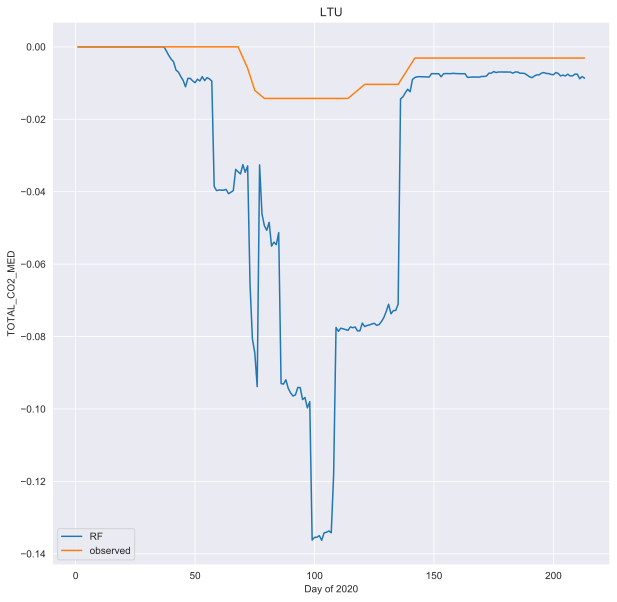

**Testing Completed**
(213, 15)
(213, 1)
RF_LOSS:  0.0034389071573469746


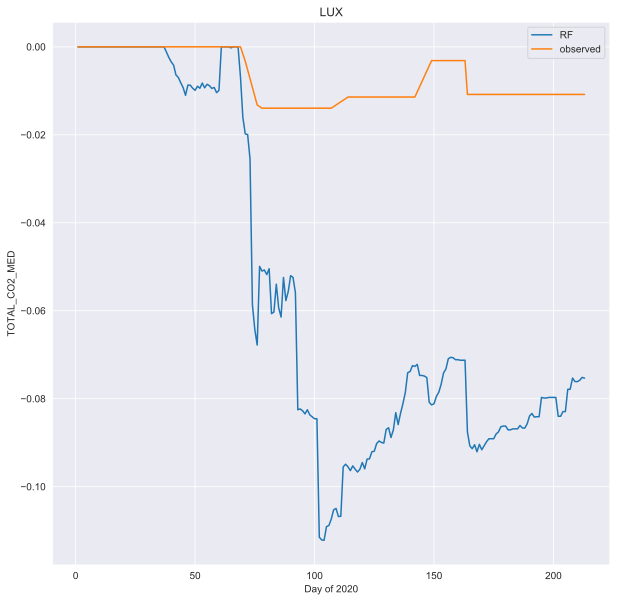

**Testing Completed**
(213, 15)
(213, 1)
RF_LOSS:  0.004918720670226826


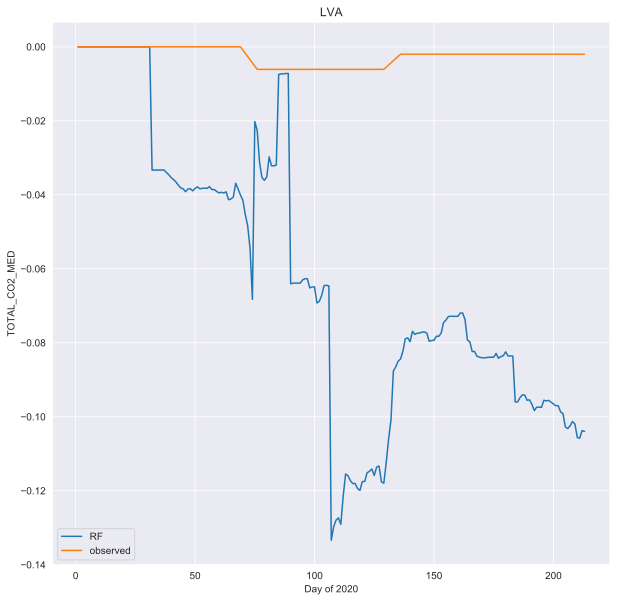

**Testing Completed**
(213, 15)
(213, 1)
RF_LOSS:  0.012194477141280888


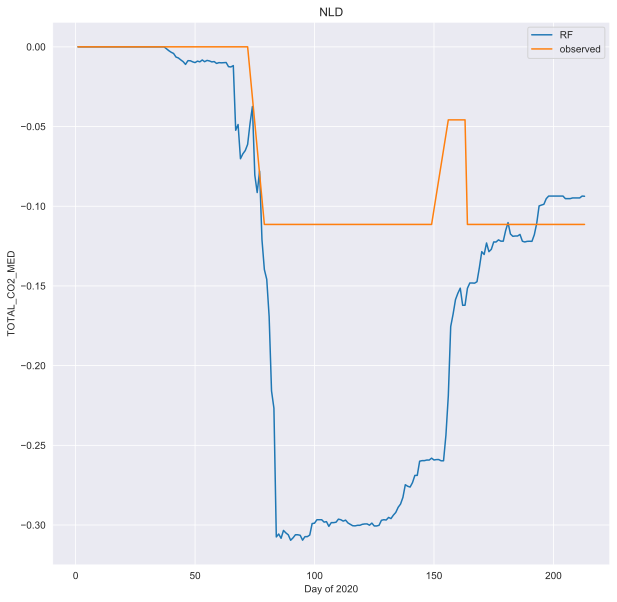

**Testing Completed**
(213, 15)
(213, 1)
RF_LOSS:  0.00015302465604747042


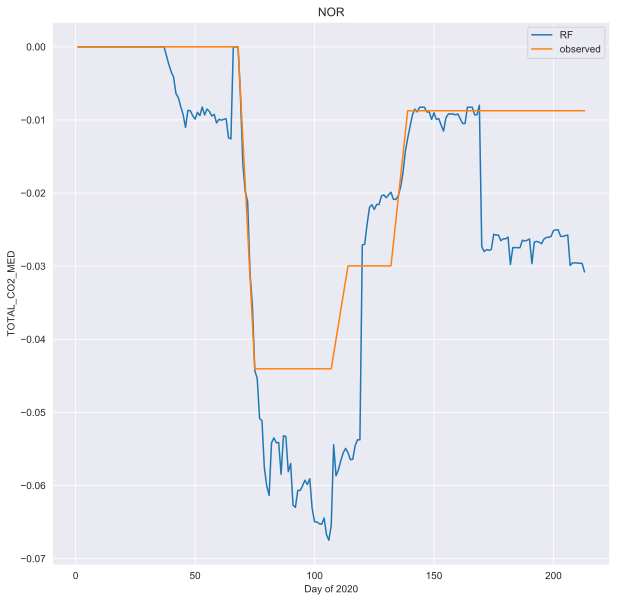

**Testing Completed**
(213, 15)
(213, 1)
RF_LOSS:  0.004588833919308841


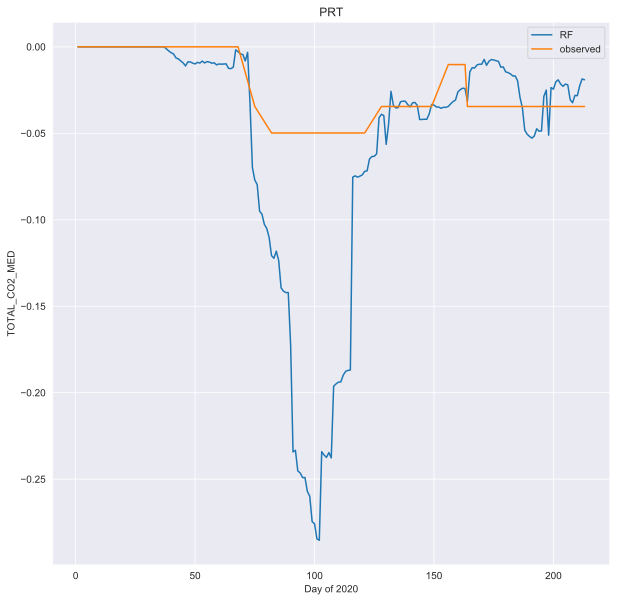

**Testing Completed**
(213, 15)
(213, 1)
RF_LOSS:  0.008059616769693486


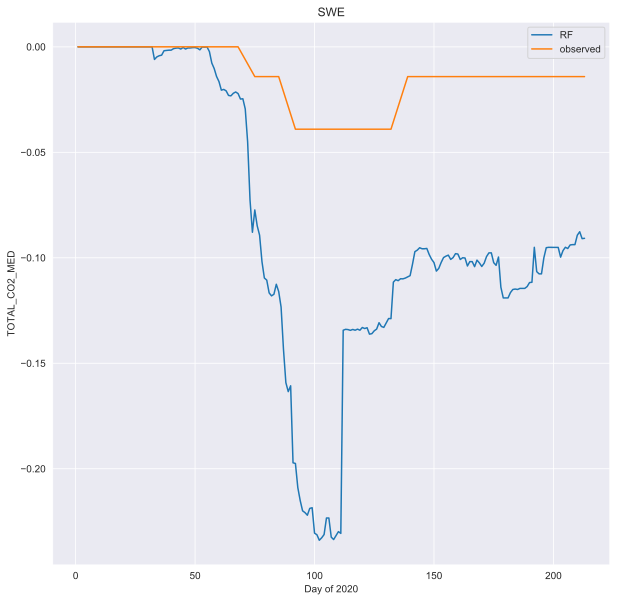

**Testing Completed**


In [32]:
best_forest_estimator = search.best_estimator_

for c in C_list[lim:]:
    
    X_test = pd.DataFrame()
    y_test = pd.DataFrame()
    
    country = data[data['ISO_Code']==c]
    
    country_feats = country.iloc[:, FEATURES]
    country_pred = country.iloc[:, PREDICTION]
    
    X_test = X_test.append(country_feats)
    y_test = pd.concat([y_test, country_pred])
    
    X_train_arr = np.asarray(X_train)
    y_train_arr = np.asarray(y_train)

    X_test_arr = np.asarray(X_test)
    y_test_arr = np.asarray(y_test)

    print(X_test_arr.shape)
    print(y_test_arr.shape)
    y_test_arr = np.nan_to_num(y_test_arr)

    y_pred_test = best_forest_estimator.predict(X_test_arr)


    print('RF_LOSS: ', np.mean((y_test_arr-y_pred_test)**2))



    days = np.array(X_test.DAY)
    plt.figure(num=None, figsize=(10, 10), dpi=200, facecolor='w', edgecolor='k')
    plt.plot(days, y_pred_test)
    plt.plot(days, y_test_arr)
    plt.title(c)
    plt.ylabel(country.columns[PREDICTION])
    plt.xlabel('Day of 2020')
    plt.title(c)
    plt.legend(["RF", "observed"])
    plt.show()


    print('**Testing Completed**')